# Probabilistic Linear Regression

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
%matplotlib inline

from Vis import plot_gaussian

np.random.seed(101)

In [3]:
def toy(N, k, alpha2=1, m0=5, beta2=10, outliers=False):
    ones = np.ones(N)
    X = np.linspace(-2, 2, N)
    X = np.vstack((ones[np.newaxis], X))

    mu0 = m0*np.ones(k)
    Sigma0 = (1./np.sqrt(beta2))*np.eye(k)
    w = np.random.multivariate_normal(mu0, Sigma0)
    print("TRUE w:", w)
    print("Var W:", np.var(w))
    Eps = np.random.normal(scale=np.sqrt(alpha2), size=[N])
    if outliers:
        Eps[-10:] = Eps[-10:] + 50
    y = X.T.dot(w) + Eps
    return X, y

In [4]:
def plot(X, y, w):
    plt.figure()
    plt.scatter(X[1], y)
    v = X.T.dot(w)
    plt.plot(X[1], v, c='r')

In [5]:
def MAP(X, y, lambd=1):
    k = X.shape[0]
    w = np.linalg.inv(X.dot(X.T) + lambd * np.eye(k)).dot(X).dot(y)
    return w

In [35]:
def Bayesian(X, y, alpha=1, mu0=None, Sigma0=None, n_max=5): #compute mean posterior and covariance 
#for each chucnk if it comes sequantialy
    k,N = X.shape
    X = X.T
    if mu0 is None:
        mu0 = np.zeros(k)
    if Sigma0 is None:
        Sigma0 = np.eye(k)

    for n in range(n_max):
        # YOUR CODE HERE compute posterior mean and posterior 
        #sigma slide 31 withlabmda and alpha computed from slide 38 - slide 45
        SigInv = np.linalg.inv(Sigma0)
        XtX = X.T @ X
        Sigma_N = np.linalg.inv(1/alpha*XtX + SigInv)
        mu_N = Sigma_N @ ((1/alpha)*X @ y + SigInv @ mu0)
        Eww = np.outer(mu_N,mu_N) + Sigma_N
        trEww = np.trace(Eww @ (X @ X.T))
        alpha = ((y @ y) - (2*y @ X.T) + trEww)/N
        print("a:", alpha)
        Sigma0 = Sigma_N
        print("S0:", Sigma0)
        mu0 = mu_N

    return Sigma_N, mu_N, alpha

In [36]:
def VariationalBayesian(X, y, a_0=1, b_0=1, alpha=.1):
    Ea = a_0 / np.float(b_0)
    k,N = X.shape
    
    Sigma_N = np.linalg.inv(Ea * np.eye(k) + (1/alpha) * X @ X.T)
    mu_N = Sigma_N @ ((1/alpha) * X @ y)
    
    Eww = mu_N @ mu_N + np.trace(Sigma_N)
    
    a_N = a_0 + 0.5 * k
    b_N = b_0 + 0.5 * Eww
    
    return Sigma_N, mu_N, a_N, b_N


In [37]:
def seqBayes(X, y, n_seq=10, alpha=1):
    _,N = X.shape
    mu_N = None
    Sigma_N = None
    idx = np.arange(N)
    np.random.shuffle(idx)
    splits = np.split(idx, n_seq)
    for idx in splits:
        
        Sigma_N, mu_N, alpha = Bayesian(X[:, idx], y[idx], alpha=alpha, mu0=mu_N, Sigma0=Sigma_N)
        w_bayes = mu_N
        print("Bayes Est w:", w_bayes)
        print("alpha:", alpha)
        plot(X, y, w_bayes)
        

    return Sigma_N, mu_N

In [38]:
def seqVarBayes(X, y, n_seq=10, alpha=0.1):
    _,N = X.shape
    a_N = 1
    b_N = 1
    idx = np.arange(N)
    np.random.shuffle(idx)
    splits = np.split(idx, n_seq)
    for idx in splits:
        Sigma_N, mu_N, a_N, b_N = VariationalBayesian(X[:, idx], y[idx], alpha=alpha, a_0=a_N, b_0=b_N)
        w_bayes = mu_N
        print("Bayes Est w:", w_bayes)
        print("E_a:", a_N/np.float(b_N))
        plot(X, y, w_bayes)
    return Sigma_N, mu_N

# Generate data

In [39]:
N = 500
k = 2
alpha = 2
X, y = toy(N, k, alpha2=alpha, outliers=True)

TRUE w: [5.12396189 4.28983816]
Var W: 0.17394059763674768


# MAP

Est w: [6.13243494 5.71526105]


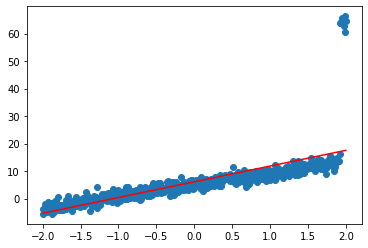

In [40]:
w_map = MAP(X,y, lambd=alpha)
print("Est w:", w_map)
plot(X, y, w_map)

EX: Please implement the missing update rules in the `Bayesian` function.

In [41]:
n_seq = 5
Sigma, mu = seqBayes(X, y, alpha=alpha, n_seq=n_seq)
print(Sigma.shape,mu.shape)
plot_gaussian(mu, Sigma, val=0.1)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 100 is different from 2)

EX: Please implement the missing update rules in the `VariationalBayesian` function.

In [13]:
Sigma, mu = seqBayes(X, y, alpha=alpha, n_seq=n_seq)

plot_gaussian(mu, Sigma, val=0.1)

ValueError: operands could not be broadcast together with shapes (4,4) (2,2) 